In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from random import shuffle
import os
import pickle

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import LSTM, Dropout, Dense
from keras import  regularizers

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [42]:
!pip install -q git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

In [4]:
def expertiesClassifier(file, yHot, y):
  if '_D00' in file or '_E00' in file: # Expert class
    yHot.append([1, 0, 0])
    y.append(0)
  if '_C00' in file or '_F00' in file: # Intermediate class
    yHot.append([0, 1, 0])
    y.append(1)
  if '_B00' in file or '_G00' in file or '_H00' in file or '_I00' in file: # Novice class
    yHot.append([0, 0, 1])
    y.append(2)
  return yHot, y

In [5]:
def taskClassifier(file, ytHot, yt):
  if 'Knot_Tying_' in file: # task 0
    ytHot.append([1, 0, 0])
    yt.append(0)
  if 'Needle_Passing_' in file: # task 1
    ytHot.append([0, 1, 0])
    yt.append(1)
  if 'Suturing_' in file: # task 2
    ytHot.append([0, 0, 1])
    yt.append(2)
  return yHot, y

### Extracting surgical data and assigning appropriate label

In [6]:
path = '/content/gdrive/My Drive/Colab Notebooks/Computer Vision/JIGSAWS_VideoData/' ### You can upload Video2ResNet generated files to your folder on Google Drive
dataSet = []
y = []
yHot = []
yt = []
ytHot = []

for r, d, f in os.walk(path):
    for file in f:
        with open(path + file, 'rb') as f:
            videoData = pickle.load(f)
            dataSet.append(videoData[0, :, :])
            expertiesClassifier(file, yHot, y)
            taskClassifier(file, ytHot, yt)

dataSet = np.asarray(dataSet)
y = np.asarray(y)
yHot = np.asarray(yHot)
yt = np.asarray(yt)
ytHot = np.asarray(ytHot)
      
print(dataSet.shape)
print(y.shape, yHot.shape)
print(yt.shape, ytHot.shape)

(206, 2048, 300)
(206,) (206, 3)
(206,) (206, 3)


In [28]:
X_ex = []
X_in = []
X_no = []
Y_ex = []
Y_in = []
Y_no = []
y_ex = []
y_in = []
y_no = []

# m, n = 11, 20 ### 5 fold CV: Number of test samples for Expert/intermediate and novice trials
m, n = 6, 10 ### 10 fold CV: Number of test samples for Expert/intermediate and novice trials
# m, n = 14, 24 ### 4 fold CV: Number of test samples for Expert/intermediate and novice trials

for i in range(dataSet.shape[0]):
  if y[i] == 0:
    X_ex.append(dataSet[i, :, :]) ###X[i, :, :38]
    Y_ex.append(yHot[i, :])
    y_ex.append(y[i])
  if y[i] == 1:
    X_in.append(dataSet[i, :, :]) ###X[i, :, :38]
    Y_in.append(yHot[i, :])
    y_in.append(y[i])
  if y[i] == 2:
    X_no.append(dataSet[i, :, :]) ###X[i, :, :38]
    Y_no.append(yHot[i, :])
    y_no.append(y[i])

X_ex = np.array(X_ex)
X_in = np.array(X_in)
X_no = np.array(X_no)
Y_ex = np.array(Y_ex)
Y_in = np.array(Y_in)
Y_no = np.array(Y_no)
y_ex = np.array(y_ex)
y_in = np.array(y_in)
y_no = np.array(y_no)

fold = 1 ### number of fold in CV (e.g., for 10 fold CV, this number can be 1,2,..., or 10)

X_test = np.vstack([X_ex[m*(fold-1):m*fold, :, :], X_in[:m, :, :], X_no[n*(fold-1):n*fold, :, :]])
Y_test = np.vstack([Y_ex[m*(fold-1):m*fold, :], Y_in[m*(fold-1):m*fold, :], Y_no[n*(fold-1):n*fold, :]])
y_test = np.hstack([y_ex[m*(fold-1):m*fold], y_in[m*(fold-1):m*fold], y_no[n*(fold-1):n*fold]])

X_train = np.append(np.vstack([X_ex[m*fold:, :, :], X_in[m*fold:, :, :], X_no[n*fold:, :, :]]), np.vstack([X_ex[:m*(fold-1), :, :], X_in[:m*(fold-1), :, :], X_no[:n*(fold-1), :, :]]), axis=0)
Y_train = np.append(np.vstack([Y_ex[m*fold:, :], Y_in[m*fold:, :], Y_no[n*fold:, :]]), np.vstack([Y_ex[:m*(fold-1), :], Y_in[:m*(fold-1), :], Y_no[:n*(fold-1), :]]), axis=0)
y_train = np.append(np.hstack([y_ex[m*fold:], y_in[m*fold:], y_no[n*fold:]]), np.hstack([y_ex[:m*(fold-1)], y_in[:m*(fold-1)], y_no[:n*(fold-1)]]), axis=0)

In [30]:
fMax = 50  ### Changing the number of first top frequency efficients for the ablation test

X_train = X_train[:, :, :fMax]
X_test = X_test[:, :, :fMax]


In [32]:
import random
ind_list = [i for i in range(len(X_test))]
random.seed(3)
random.shuffle(ind_list)
X_new  = X_test[ind_list, :,:]
Y_new = Y_test[ind_list,]
y_new = y_test[ind_list,]
X_test = X_new
Y_test = Y_new
y_test = y_new

ind_list = [i for i in range(len(X_train))]
random.seed(4)
random.shuffle(ind_list)
X_new  = X_train[ind_list, :,:]
Y_new = Y_train[ind_list,]
y_new = y_train[ind_list,]
X_train = X_new
Y_train = Y_new
y_train = y_new

AllHistories = {}

In [84]:
n=32
l = 64
m=128

inputs = keras.Input(shape=X_train.shape[1:])
x = layers.Conv1D(filters=n, kernel_size=3, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.03)(x)

x = layers.Conv1D(filters=l, kernel_size=3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.03)(x)

x =  layers.Conv1D(filters=m, kernel_size=3, strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.03)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(3, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

print(model.summary())
# keras.utils.plot_model(model, "ResNetModel.png", show_shapes=True)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 2048, 50)]        0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 2048, 32)          4832      
_________________________________________________________________
batch_normalization_45 (Batc (None, 2048, 32)          128       
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 2048, 32)          0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 2048, 64)          6208      
_________________________________________________________________
batch_normalization_46 (Batc (None, 2048, 64)          256       
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 2048, 64)          0  

In [81]:
starter_learning_rate = 0.05
end_learning_rate = 0.01
decay_steps = 10000
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.5)

model.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adadelta(lr_schedule),
            metrics=['accuracy'])

checkpoint_path = "trainingWeights/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=1)

epochs = 200
batch_size = 128
MyHistory = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[cp_callback,],
          verbose=1,
          validation_data=(X_test, Y_test))

AllHistories['CNN'+str(i)] = MyHistory

Epoch 1/200
2/2 [==============================] - 1s 343ms/step - loss: 1.2786 - accuracy: 0.4253 - val_loss: 1.2052 - val_accuracy: 0.3636

Epoch 00001: saving model to trainingWeights/cp-0001.ckpt
Epoch 2/200
2/2 [==============================] - 0s 79ms/step - loss: 2.4385 - accuracy: 0.3065 - val_loss: 2.5566 - val_accuracy: 0.4545

Epoch 00002: saving model to trainingWeights/cp-0002.ckpt
Epoch 3/200
2/2 [==============================] - 0s 76ms/step - loss: 1.7089 - accuracy: 0.4476 - val_loss: 5.3878 - val_accuracy: 0.4545

Epoch 00003: saving model to trainingWeights/cp-0003.ckpt
Epoch 4/200
2/2 [==============================] - 0s 75ms/step - loss: 1.3060 - accuracy: 0.6437 - val_loss: 2.9759 - val_accuracy: 0.4545

Epoch 00004: saving model to trainingWeights/cp-0004.ckpt
Epoch 5/200
2/2 [==============================] - 0s 74ms/step - loss: 0.7760 - accuracy: 0.6457 - val_loss: 2.3143 - val_accuracy: 0.4545

Epoch 00005: saving model to trainingWeights/cp-0005.ckpt
Epoc

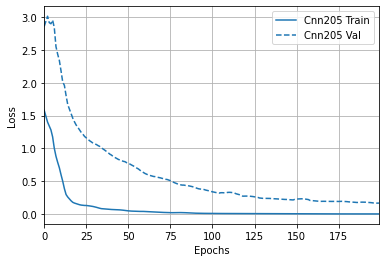

In [87]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=1)
plotter.plot(AllHistories)

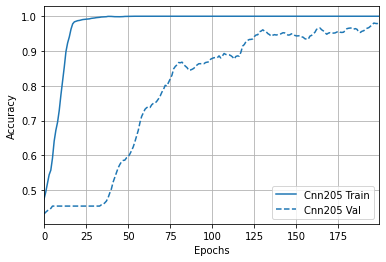

In [88]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=1)
plotter.plot(AllHistories)